## Tutorial on Stochastic Optimization within Particle Filters

### We break this tutorial up into three distinct components:

1. Setting up the model.
2. Plotting the likelihood of the parameters in a 1-dimensional setting (projection plots).
3. Running the stochastic Optimization algorithm for the problem.

### 1. Setting up the model

The model is defined below, where each sample is obtained identically and independentally distributed from the distribution on the right hand side. Here we only have a single observation $y_t$ and we have a constant $dt$ through which we never need to take derivatives. Note that with $\pi(x_0) \propto 1$, we may condition on $y_0$ and obtain $x_0 \mid y_0 \sim \N(y_0, \tau^2)$.

$$\begin{aligned}
x_0 & \sim \pi(x_0) \\
x_t & \sim \mathcal{N}(x_{t-1} + \mu dt, \sigma^2 dt) \\
y_t & \sim \mathcal{N}(x_t, \tau^2).
\end{aligned}$$

Text(0.5, 1.0, 'Latent Variable(x_state) and Observation(y_meas)')

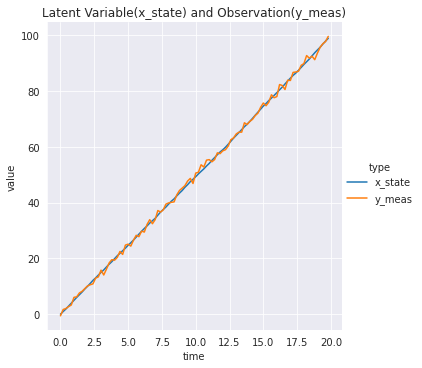

In [2]:
import numpy as np
import jax
import jax.numpy as jnp
import jax.scipy as jsp
import jax.random as random
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
# utility for plotting
import projplot as pjp

# module containing pfjax (for now)
import pfjax as pf

from pfjax.models import BMModel

# initial key for random numbers
key = random.PRNGKey(0)
sns.set_style("darkgrid")
# parameter values
mu = 5.
sigma = .2
tau = 1.
theta = np.array([mu, sigma, tau])

# data specification
dt = .2
n_obs = 100
x_init = jnp.array([0.])

# simulate data
bm_model = BMModel(dt=dt)
key, subkey = random.split(key)
y_meas, x_state = pf.simulate(bm_model, key, n_obs, x_init, theta)

# plot data
plot_df = (pd.DataFrame({"time": jnp.arange(n_obs) * dt,
                         "x_state": jnp.squeeze(x_state),
                         "y_meas": jnp.squeeze(y_meas)})
           .melt(id_vars="time", var_name="type"))
sns.relplot(
    data=plot_df, kind="line",
    x="time", y="value", hue="type"
)
plt.title("Latent Variable(x_state) and Observation(y_meas)")

The code above simulates data from the model class, `BMModel`, from the particle filter library and provides it with an initial key, `key`, a number of observations, `nobs`,  an initial starting point for the parameters, `x_init` as well as the parameter values, `theta`. To instantiate the model itself, there are other considerations that need to be taken that are omitted for brevity from this tutorial. With regards to the data types here:

1. `key` is a jax specific device-array.
2. `nobs` is an integer.
3. `x_init` is an initial jax device-array.
4. `theta` is a numpy array (Note: it can also be a jax device array).

### 2. Projection Plots

Now that we have an understanding of the basics required to simulate data from a model, we will move on to obtaining projection plots for our results.

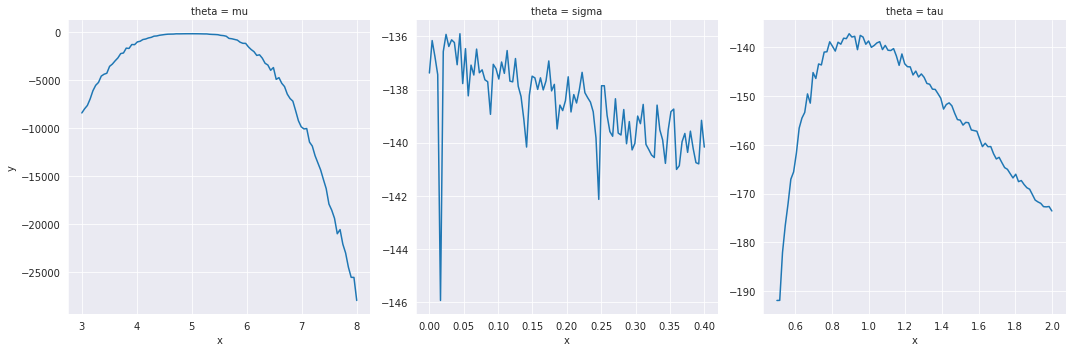

In [8]:
def proj_data(fun, x, x_lims, x_names, n_pts=100):
    """
    Wrapper for projxvals and projdata.
    """
    xvals = pjp.projxvals(x, x_lims, n_pts)
    return pjp.projdata(fun, xvals, x_names, is_vectorized=False)

theta_lims = np.array([[3., 8.], [0., .4], [.5, 2]])
theta_names = ["mu", "sigma", "tau"]
n_pts = 100

@jax.jit
def bm_pflik(theta):
    temp = pf.particle_filter(theta=theta, model=bm_model, y_meas=y_meas,
                              n_particles=100, key=key)
    return pf.particle_loglik(temp['logw'])


plot_df = proj_data(bm_pflik,
                    theta, theta_lims, theta_names)

The projection plots provide us with a rough idea of whether the given problem is amenable to stochastic optimization or not. We note that for each of the parameters, we notice that while holding all other parameter values constant and varying just that parameter, we obtain modes are roughly the true value we used to simulate the results to begin with.

### 3. Running Stochastic Optimization

In order to run stochastic optimization for this particular problem, we make use of an algorithm provided by Poyiadjis et al. (2011) which stores intermediary information in order to efficiently compute the gradient and hessian. Once we have access to the gradient and hessian, we may take a step in the direction of the gradient and run this for a prespecified number of iterations to arrive at a convergent value. At the converged value, we may make use of an method to obtain inference results.

In order to implement the stochastic optimizer we must implement two functions: 

1. `update_params_acc`
2. `stoch_opt_acc`

The `update_params_acc` takes in a set of parameters along with the state of the optimizer for a given iteration. With this information, the function will update the parameter value by taking a step in the direction of the gradient (for gradient ascent, or negative gradient in the case of gradient descent). For the purposes of this tutorial, we will utilize a JAX library for stochastic opitimization called `optax` which presents tools for running stochastic optimization. For further documentation please refer to [the official documentation](https://github.com/deepmind/optax).

Next, we require a function that would run the stochastic optimizer for a pre-specified number of iterations. This is done through the `stoch_opt_acc` functions which performs the following tasks:

1. Initializes the `optax` optimizer with a learning rate.
2. Partially evaluates the `update_params_acc` function which allows it to be JIT compiled.
3. Samples keys for every iteration that the particle filter will be run for.
4. Runs the particle filter.
5. Returns the parameter output and the hessian at that parameter value.

In [13]:
import optax
from functools import partial
import pfjax.experimental.particle_filter as pfex

def update_params_acc(params, subkey, opt_state, n_particles=100,
                      y_meas=None, mask=None, optimizer=None):
    '''
    Updates the parameters with respect to the current optimizer state and takes a step in the gradient.
    Using `y_meas, `params`, subkey and `opt_state`, this function runs a single iteration of the particle filter 
    and then masks out the parameters that are held constant to yield the updated parameter values.
    Args:
        params: A jnp.array that represents the values of the parameters before the gradient update.
        subkey: The subkey for the current loop iteration.
        opt_state: The optimizer state of the parameters.
        n_particles: The number of particles for the particle filter.
        y_meas: The observed data `y_meas`
        mask: A mask (0 or 1 vector) which represents the parameters that we wish to update in an iteration.
        optimizer: The choice of stochastic optimizer (e.g. Adam/Adagrad)
    
    Returns:
        params: The updated parameters at the end of the stochastic optimization step.
    '''
    # Run the particle filter to obtain the output.
    # Please note that `score` and `fisher` have to be set to `True`
    # otherwise, this code segment will fail.
    out = pfex.particle_filter(
        model=bm_model,
        key=subkey,
        y_meas=y_meas,
        theta=params,
        n_particles=n_particles,
        score=True,
        fisher=True,
        history=False
    )
    score = out["score"]
    hess = out["fisher"]
    updates, opt_state = optimizer.update(-1.0 * score, opt_state)
    return optax.apply_updates(params, updates), hess


def stoch_opt_acc(params, y_meas, n_particles=100, iterations=10,
              learning_rate=0.01, key=1, mask=None):
    """
    Driver function for running the stochastic optimization algorithm.
    Args:
        params: A jnp.array that represents the initial values of the parameters.
        y_meas: The measurements of the observations required for the particle filter.
        n_particles: The number of particles to use in the particle filter.
        iterations: The number of iterations to run the gradient descent for.
        key: The key required for the prng.
        mask: The mask over which dimensions we would like to perform the optimization.
    
    Returns:
        params: The final value of the parameters.
    """
    # Choose an optimizer here.
    optimizer = optax.adam(learning_rate)
    # Initialize the optimizer to the initial value of the parameters that we would like to start with.
    opt_state = optimizer.init(params)
    # Partially evaluate the function with respect to all of the parameters that do not change over time.
    partial_update_params = partial(update_params_acc, n_particles=n_particles, y_meas=y_meas,
                                    mask=mask, optimizer=optimizer)
    # JIT the update step.
    update_fn = jax.jit(partial_update_params, donate_argnums=(0,))
    # Every iteration, the keys must be split to obtain several subkeys for which we have to take the update step.
    keys = random.split(key, iterations)
    for subkey in keys:
        params, hess = update_fn(params, subkey, opt_state)
    return params, hess

In [21]:
params = stoch_opt_acc(jnp.array([1.0, 1.0, 1.0]),  y_meas, key=key, learning_rate=0.01, iterations=1000, n_particles=200,
         mask=np.array([1,1,1]))
params

(DeviceArray([4.979973 , 0.1200061, 0.9400004], dtype=float32),
 DeviceArray([[ -739.6729  ,  2753.6838  ,    19.159538],
              [ 2753.6838  , 16355.693   ,   434.33154 ],
              [   19.159538,   434.33154 ,  -220.75412 ]], dtype=float32))